In [1]:
# Standard modules
import pdb
import sys
import os
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sys.path.append("..")

from simstackwrapper import SimstackWrapper
from simstacktoolbox import SimstackToolbox

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# This step is necessary if you split the bootstrap into multiple chunks.

Bootstraps take a long time so, if you can, it makes sense to split the job among several machines/cores, and combine the results, as shown here. This is a 4 step process
1. **Make a new directory to store the merged pickle.**  For example, in the example below the stack is split into 1-50, 51-100, 101-130, 131-150, then a create directory 1-150 needs to be created, i.e.; cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8_10p0_X_5_foregnd_atonce_bootstrap_1-150
2. **Add and edit a config file.** Inside that directory you need to copy the config file (e.g., cosmos2020_farmer.ini) and edit the bootstrap bins to reflect the merge. i.e.; error_estimator = {"bootstrap": {"initial_bootstrap": 1, "iterations": 150}, "write_simmaps": 0, "randomize": 0}
3. **Create a dictionary** defining the names of the pickles and the config file to be merged in the pickle_file_dict format outlined below. 
4. **Run merge_stack_and_catalog_pickles(pickle_dict)** This creates the merged pickle in the created directory.  The example below.  

### SIDES Simulation

In [2]:
pickle_file_dict = {'stack_dirs': ['sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8p0_X_4_foregnd_atonce_bootstrap_1-20', 
                                   'sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8p0_X_4_foregnd_atonce_bootstrap_21-40',
                                   'sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8p0_X_4_foregnd_atonce_bootstrap_41-60',
                                   'sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8p0_X_4_foregnd_atonce_bootstrap_61-80'], 
                    'underscore_suffix': '', 
                    'merged_dir': 'sides_allz_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8p0_X_4_foregnd_atonce_bootstrap_1-80',
                    'config_filename': 'sides_simulation.ini',
                    'pickle_path':os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities","spire")}

In [3]:
def merge_stack_and_catalog_pickles(pickle_dict, keep_full_catalog=True, save_pickle=True, overwrite_pickle=False):
    
    pickle_path_combined = os.path.join(pickle_dict['pickle_path'],pickle_dict['merged_dir']+pickle_dict['underscore_suffix'])
    path_save_pickle = os.path.join(pickle_path_combined,pickle_dict['merged_dir']+'.pkl')
    
    if os.path.isfile(path_save_pickle) and not overwrite_pickle:
        return SimstackToolbox.import_saved_pickles(path_save_pickle)
    
    for iobj, path_obj in enumerate(pickle_dict['stack_dirs']):
        path_object = os.path.join(pickle_dict['pickle_path'],path_obj+pickle_dict['underscore_suffix'],path_obj+'.pkl')

        if os.path.isfile(path_object):
            temp_object = SimstackToolbox.import_saved_pickles(path_object)
        else:
            print(path_object ,' does not exist')
            break
                
        if not iobj:
            merge_object = temp_object
        else:
            merge_object.combine_objects(temp_object)

        if keep_full_catalog:
            path_ini_file = os.path.join(pickle_path_combined, pickle_dict['config_filename'])
            if os.path.isfile(path_ini_file):
                catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
                merge_object.catalog_dict['tables']['full_table'] = catalog_object.catalog_dict['tables']['full_table']
            else:
                print(path_ini_file ,' does not exist')
                break
        
        if save_pickle:            
            SimstackToolbox.save_to_pickles(path_save_pickle, merge_object)
                
    return merge_object

In [4]:
# Merge and Save to Pickle
save_pickle = True
merged_object = merge_stack_and_catalog_pickles(pickle_file_dict, save_pickle=save_pickle, overwrite_pickle=True)

# OPTIONALLY INSPECT MERGED FLUXES

In [5]:
from simstackresults import SimstackResults
merged_object = SimstackResults(merged_object)

In [6]:
merged_object.parse_results(catalog_object=merged_object, estimate_mcmcs=False)

In [7]:
from simstackplots import SimstackPlots
merged_object = SimstackPlots(merged_object)

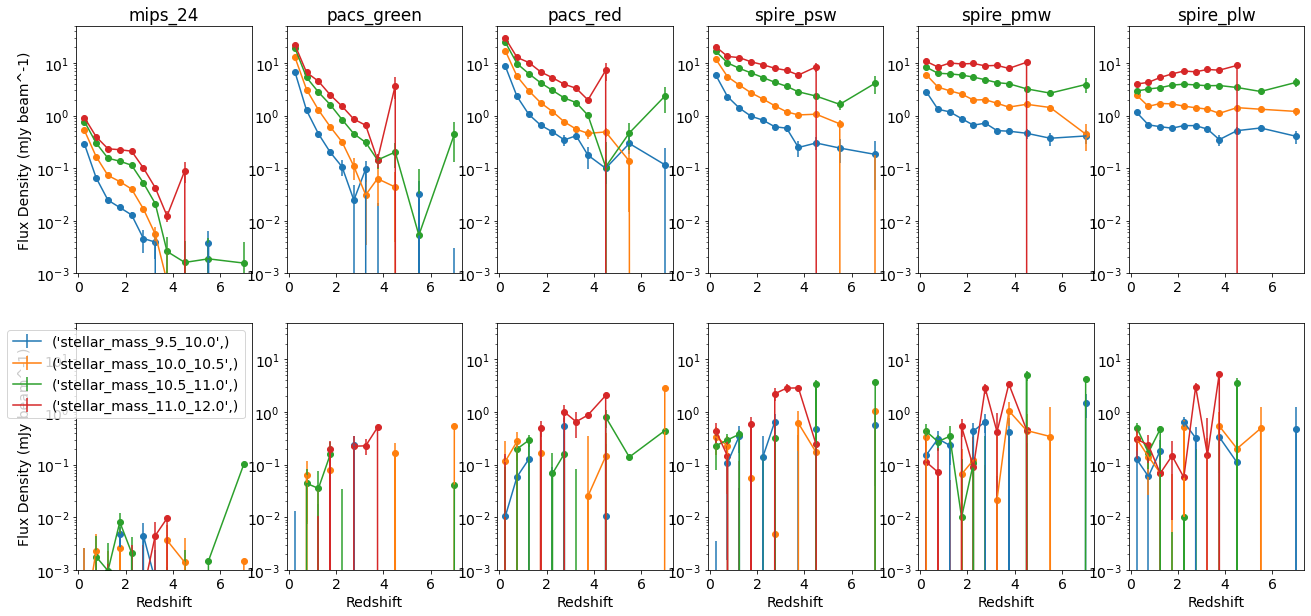

In [8]:
merged_object.plot_flux_densities()

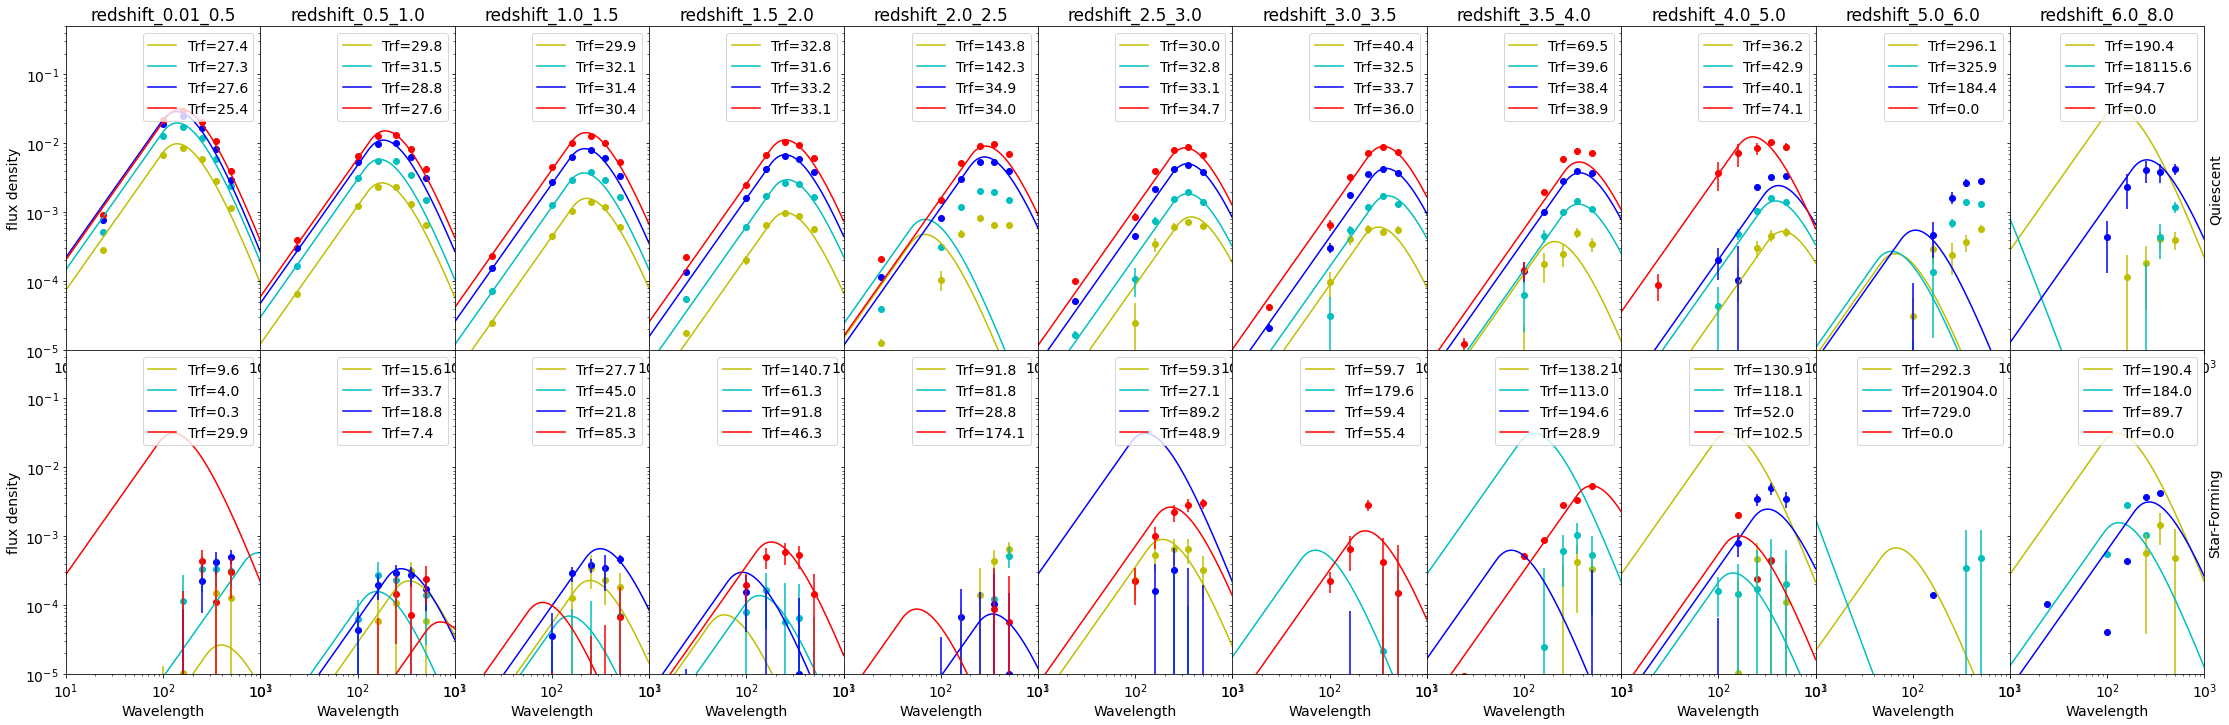

In [9]:
merged_object.plot_seds(merged_object.results_dict['sed_bootstrap_results_dict'])